In [1]:
import time, os, random
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.distributions.categorical import Categorical
import matplotlib as mpl
from scipy.stats import ortho_group, special_ortho_group
import copy

# mpl.use('TkAgg')
# mpl.use('agg')

pi = torch.tensor(math.pi)
epsilon = torch.tensor(1e-5)
epsilonPi = torch.tensor(0.01)
device = 'cpu'


def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [2]:
def GMM_logprobs_Full(x, pi_q, mu_q, Sigma_q, mask=None):
    '''
    K number of components, N number of samples, D dimension of each observation
    :param x:    N,D
    :param pi_q: K,1 or N,K
    :param mu_q: K,D
    :param std_q: K,D,D
    :param mask: N,D
    :return:
    '''
    N, D = x.shape

    t1 = torch.log(pi_q).squeeze()  # K or N,K
    t2 = - D / 2. * torch.log(2. * pi)  #
    t3 = - 0.5 * torch.logdet(Sigma_q)  # K
    x_mu = x.unsqueeze(1) - mu_q.unsqueeze(0)  # N,K,D
    t4 = - 0.5 * torch.matmul(
        x_mu.unsqueeze(-2),
        torch.matmul(torch.inverse(Sigma_q), x_mu.unsqueeze(-1))
    ).squeeze(-1).squeeze(-1)  # N,K

    log_Normal = t2 + t3 + t4  # [N, K]
    log_piNormal = t1 + log_Normal  # [N, K]
    log_gmm = torch.logsumexp(log_piNormal, dim=1, keepdim=True)  # N,1

    return log_gmm, log_piNormal, log_Normal

def GMM_sample_n(pi_q, mu_q, std_q, n):
    dim_x = mu_q.shape[1]
    mode_var = Categorical(pi_q.squeeze())
    m = mode_var.sample((n,))
    data = mu_q[m, :] + std_q[m, :] * torch.randn([n, dim_x], device=device)
    return data.type(torch.float32), m

def KL_gmm_Full(x_test, pi_q, mu_q, Sigma_q, pi_p, mu_p, Sigma_p):
    log_gmm_q, _, _ = GMM_logprobs_Full(x_test, pi_q, mu_q, Sigma_q)  # N,1
    log_gmm_p, _, _ = GMM_logprobs_Full(x_test, pi_p, mu_p, Sigma_p)  # N,1
    KL_test = (log_gmm_q - log_gmm_p).mean()
    return KL_test

def KL_gmm_condition_Full(x_test, pi_q, mu_q, Sigma_q, pi_p, mu_p, Sigma_p, Sindx, Tindx):
    log_gmm_qST, _, _ = GMM_logprobs_Full(x_test[:, Sindx + Tindx], pi_q,
                                          mu_q[:, Sindx + Tindx],
                                          Sigma_q[:, Sindx + Tindx, :][:, :, Sindx + Tindx])  # N,1  N,K
    log_gmm_qS, _, _ = GMM_logprobs_Full(x_test[:, Sindx], pi_q,
                                         mu_q[:, Sindx],
                                         Sigma_q[:, Sindx, :][:, :, Sindx])  # N,1  N,K
    log_gmm_qTgS = log_gmm_qST - log_gmm_qS

    log_gmm_pST, _, _ = GMM_logprobs_Full(x_test[:, Sindx + Tindx], pi_p,
                                          mu_p[:, Sindx + Tindx],
                                          Sigma_p[:, Sindx + Tindx, :][:, :, Sindx + Tindx])  # N,1  N,K
    log_gmm_pS, _, _ = GMM_logprobs_Full(x_test[:, Sindx], pi_p,
                                         mu_p[:, Sindx],
                                         Sigma_p[:, Sindx, :][:, :, Sindx])  # N,1  N,K
    log_gmm_pTgS = log_gmm_pST - log_gmm_pS

    KL_test = (log_gmm_qTgS - log_gmm_pTgS).mean()
    return KL_test

def contourplot_gmm_Full(pi_q, mu_q, Sigma_q, pi_p, mu_p, Sigma_p, x_all=None, num_points=100, fontsize=14):
    inds = torch.linspace(-5.0, 5.0, num_points)
    inds_y, inds_x = torch.meshgrid(inds, inds)
    XY = torch.cat((inds_x.reshape(-1, 1), inds_y.reshape(-1, 1)), dim=1)  # N,D

    QXY, _, _ = GMM_logprobs_Full(XY, pi_q, mu_q, Sigma_q)  # N,1
    PXY, _, _ = GMM_logprobs_Full(XY, pi_p, mu_p, Sigma_p)  # N,1
    QXY = QXY.exp().reshape(num_points, num_points)
    PXY = PXY.exp().reshape(num_points, num_points)

    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    cntr1 = ax.contour(inds_x.numpy(), inds_y.numpy(), PXY.numpy(), 8, alpha=0.5,
                       colors='green')
    cntr2 = ax.contour(inds_x.numpy(), inds_y.numpy(), QXY.numpy(), 8, alpha=0.5,
                       colors='red')
    h1, _ = cntr1.legend_elements()
    h2, _ = cntr2.legend_elements()
    ax.legend([h1[0], h2[0]], [r'$p_{\theta}(x)$', r'$q(x)$'], fontsize=fontsize+2)
    for ii in range(pi_p.numel()):
        ax.annotate(r'$\pi_{%d}=%.2f$' % (ii, pi_p[ii].numpy()),
                    xy=(mu_p[ii, 0].numpy(), mu_p[ii, 1].numpy()),
                    xytext=(+15, -15), textcoords='offset points', fontsize=fontsize,
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

    if x_all is not None:
        plt.scatter(x_all[:, 0], x_all[:, 1])

def rand_mat(dim=2, method='orthogonal'):
    # method = 'rotation', 'orthogonal'
    if method == 'orthogonal':
        A = torch.tensor(ortho_group.rvs(dim), dtype=torch.float32)  # Orthogonal
    elif method == 'rotation':
        A = torch.tensor(special_ortho_group.rvs(dim), dtype=torch.float32)  # Rotation
    else:
        print('Invalid input for <method>')
    return A

def correct_Sigma(Sigma_p, eps=1e-5):  # , method='max', eps=1e-2):
    if True:
        L, V = torch.linalg.eigh(Sigma_p)
        # torch.dist(V @ torch.diag_embed(L) @ torch.linalg.inv(V), Sigma_p)
        Sigma_p = V @ torch.diag_embed(
            torch.maximum(torch.tensor(eps), L)
        ) @ torch.linalg.inv(V)
    else:
        _, info = torch.linalg.cholesky_ex(Sigma_p)
        if (info > 0).any():
            L, V = torch.linalg.eigh(Sigma_p)
            # torch.dist(V @ torch.diag_embed(L) @ torch.linalg.inv(V), Sigma_p)
            Sigma_p = V @ torch.diag_embed(
                torch.maximum(torch.tensor(eps), L)
            ) @ torch.linalg.inv(V)
            # K, D, _ = Sigma_p.shape
            # Ks, Ds = torch.meshgrid(torch.arange(K), torch.arange(D))
            # if method == 'max':
            #     L[Ks, Ds, Ds] = torch.maximum(torch.tensor(eps), L[Ks, Ds, Ds])
            # else:
            #     L[Ks, Ds, Ds] = L[Ks, Ds, Ds].abs()
            # Sigma_p = torch.matmul(L, torch.transpose(L, 1, 2))
            # Sigma_p1 = torch.matmul(L, torch.transpose(L, 1, 2))
            # L1, info1 = torch.linalg.cholesky_ex(Sigma_p1)
    return Sigma_p


Settings

In [3]:
# random_seedS = torch.randint(10000, (10,))  # 888
random_seedS = torch.tensor([5079, 6395, 3325, 2580, 5755, 2488, 4515, 6607, 2432, 6064])

Niter = 2000
NITnei = 5
plotIT = 50

out_dir = 'E:/ExperiResults/BigLearnEM/'
os.makedirs(out_dir) if not os.path.isdir(out_dir) else None

Data settings

In [4]:
x_dim = 2
num_data = 2000
num_data_test = 5000

NpiIT = 10
lrSGD = 1  # 5e-3

num_component = 25
pi_q = 1. / num_component * torch.ones(num_component, 1, device=device)
mu_q = torch.tensor([[1, 1], [1, 2], [1, 3], [1, 4], [1, 5],
                     [2, 1], [2, 2], [2, 3], [2, 4], [2, 5],
                     [3, 1], [3, 2], [3, 3], [3, 4], [3, 5],
                     [4, 1], [4, 2], [4, 3], [4, 4], [4, 5],
                     [5, 1], [5, 2], [5, 3], [5, 4], [5, 5]], device=device, dtype=torch.float32) * 2 - 6
std_q = torch.sqrt(torch.tensor([0.1], device=device)) * torch.ones(num_component, x_dim, device=device)
Sigma_q = torch.diag_embed(std_q.pow(2))  # K,D,D

# x_all, y_all = GMM_sample_n(pi_q, mu_q, std_q, num_data)
# x_test, y_test = GMM_sample_n(pi_q, mu_q, std_q, num_data_test)


<1> Joint-EM

In [5]:
jointKL_testS_ALL, jointITS_ALL = [], []
Margin1KL_testS_ALL, Margin2KL_testS_ALL = [], []
Condition1KL_testS_ALL, Condition2KL_testS_ALL = [], []

Theta_ALL = []

In [6]:
if False:
    for irand, random_seed in enumerate(random_seedS):
        seed_torch(random_seed)
        x_all, y_all = GMM_sample_n(pi_q, mu_q, std_q, num_data)
        x_test, y_test = GMM_sample_n(pi_q, mu_q, std_q, num_data_test)

        jointKL_testS, jointITS = [], []
        Margin1KL_testS, Margin2KL_testS = [], []
        Condition1KL_testS, Condition2KL_testS = [], []

        pi_p = 1. / num_component * torch.ones(num_component, 1, device=device)
        mu_p = torch.randn(num_component, x_dim, device=device)
        Sigma_p = torch.diag_embed(torch.ones(num_component, x_dim, device=device))

        # for IT in range(Niter):
        for IT in range(500):
            # E
            log_gmm, log_piNormal, _ = GMM_logprobs_Full(x_all, pi_p, mu_p, Sigma_p)  # N,1  N,K
            qzgx = (log_piNormal - log_gmm).exp()  # N,K
            # M
            pi_p = qzgx.mean(0).unsqueeze(-1)  # K,1
            mu_p = (qzgx.unsqueeze(2) * x_all.unsqueeze(1)).mean(0) / torch.maximum(epsilon, pi_p)  # K,D
            x_mu = x_all.unsqueeze(1) - mu_p.unsqueeze(0)  # N,K,D
            Sigma_p = (qzgx.unsqueeze(2).unsqueeze(3) * torch.matmul(x_mu.unsqueeze(-1), x_mu.unsqueeze(-2))
                       ).mean(0) / torch.maximum(epsilon, pi_p).unsqueeze(-1)  # K,D,D
            Sigma_p = correct_Sigma(Sigma_p)

            jointKL_test = KL_gmm_Full(x_test, pi_q, mu_q, Sigma_q, pi_p, mu_p, Sigma_p)
            jointKL_testS.append(jointKL_test)
            jointITS.append(IT)

            Tindx1 = torch.tensor([1, 0]) > 0
            Tx = torch.where(Tindx1)[0]  # K,D,D
            Tx1, Tx2, Tx3 = torch.meshgrid(torch.arange(mu_p.shape[0]), Tx, Tx)
            Margin1KL_testS.append(
                KL_gmm_Full(x_test[:, Tindx1], pi_q, mu_q[:, Tindx1], Sigma_q[Tx1, Tx2, Tx3], pi_p, mu_p[:, Tindx1],
                            Sigma_p[Tx1, Tx2, Tx3])
            )

            Tindx2 = torch.tensor([0, 1]) > 0
            Tx = torch.where(Tindx2)[0]  # K,D,D
            Tx1, Tx2, Tx3 = torch.meshgrid(torch.arange(mu_p.shape[0]), Tx, Tx)
            Margin2KL_testS.append(
                KL_gmm_Full(x_test[:, Tindx2], pi_q, mu_q[:, Tindx2], Sigma_q[Tx1, Tx2, Tx3], pi_p, mu_p[:, Tindx2],
                            Sigma_p[Tx1, Tx2, Tx3])
            )

            Sindx1 = torch.tensor([0, 1]) > 0
            Tindx1 = torch.tensor([1, 0]) > 0
            Condition1KL_testS.append(
                KL_gmm_condition_Full(x_test, pi_q, mu_q, Sigma_q, pi_p, mu_p, Sigma_p, Sindx1, Tindx1)
            )

            Sindx2 = torch.tensor([1, 0]) > 0
            Tindx2 = torch.tensor([0, 1]) > 0
            Condition2KL_testS.append(
                KL_gmm_condition_Full(x_test, pi_q, mu_q, Sigma_q, pi_p, mu_p, Sigma_p, Sindx2, Tindx2)
            )

            if IT % 100 ==0:
                print('irand=%d, random_seed=%d, IT=%d, JointKL=%.5f, Margin1KL=%.5f, Margin2KL=%.5f, Condition1KL=%.5f, Condition2KL=%.5f' % (
                    irand, random_seed, IT, jointKL_testS[-1], Margin1KL_testS[-1], Margin2KL_testS[-1], Condition1KL_testS[-1], Condition2KL_testS[-1]))

        jointKL_testS_ALL.append(jointKL_testS)
        jointITS_ALL.append(jointITS)
        Margin1KL_testS_ALL.append(Margin1KL_testS)
        Margin2KL_testS_ALL.append(Margin2KL_testS)
        Condition1KL_testS_ALL.append(Condition1KL_testS)
        Condition2KL_testS_ALL.append(Condition2KL_testS)

        Theta_ALL.append((pi_p, mu_p, Sigma_p))

    torch.save((jointKL_testS_ALL, jointITS_ALL, Margin1KL_testS_ALL, Margin2KL_testS_ALL, Condition1KL_testS_ALL, Condition2KL_testS_ALL, Theta_ALL, random_seedS),
               out_dir + 'JointEM_States_AllSeeds_Full.pt')

else:
    jointKL_testS_ALL, jointITS_ALL, Margin1KL_testS_ALL, Margin2KL_testS_ALL, Condition1KL_testS_ALL, Condition2KL_testS_ALL, Theta_ALL, random_seedS = torch.load(out_dir + 'JointEM_States_AllSeeds_Full.pt')


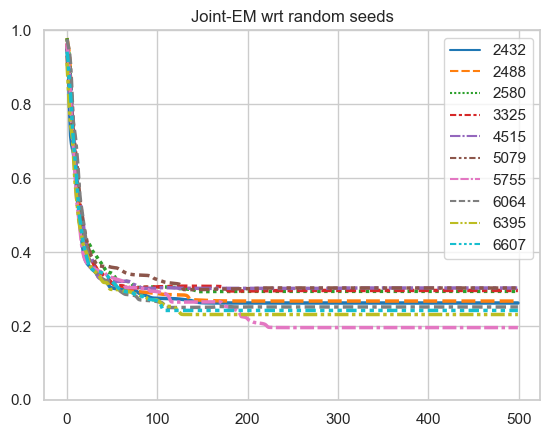

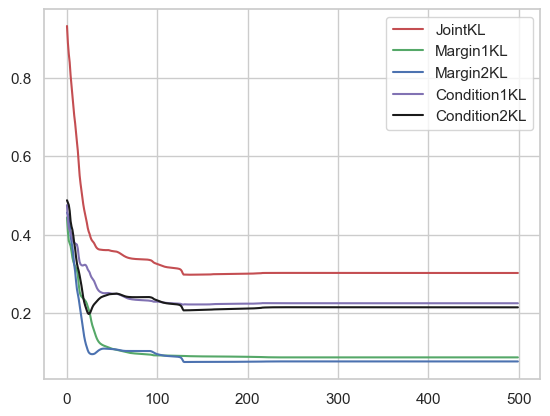

C:\ProgramData\Anaconda3\envs\env202210\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


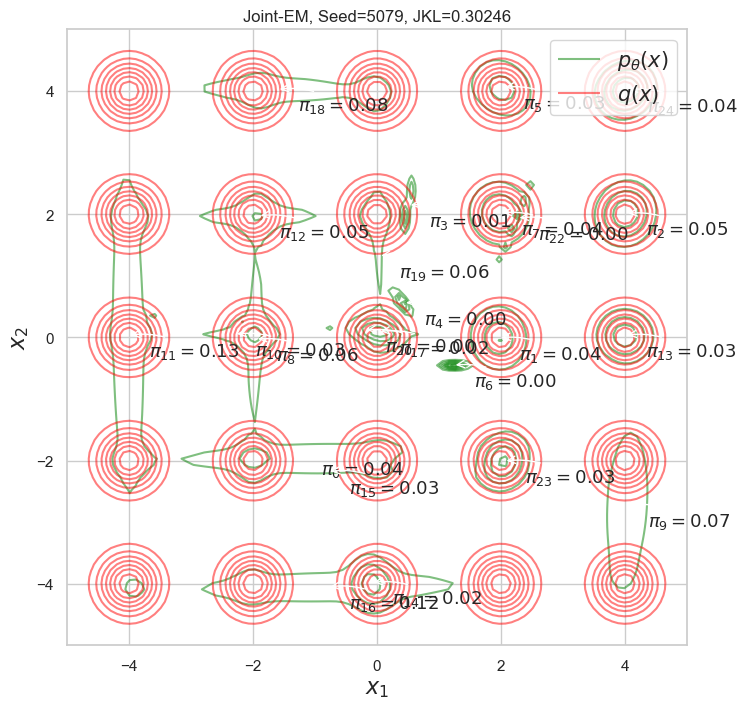

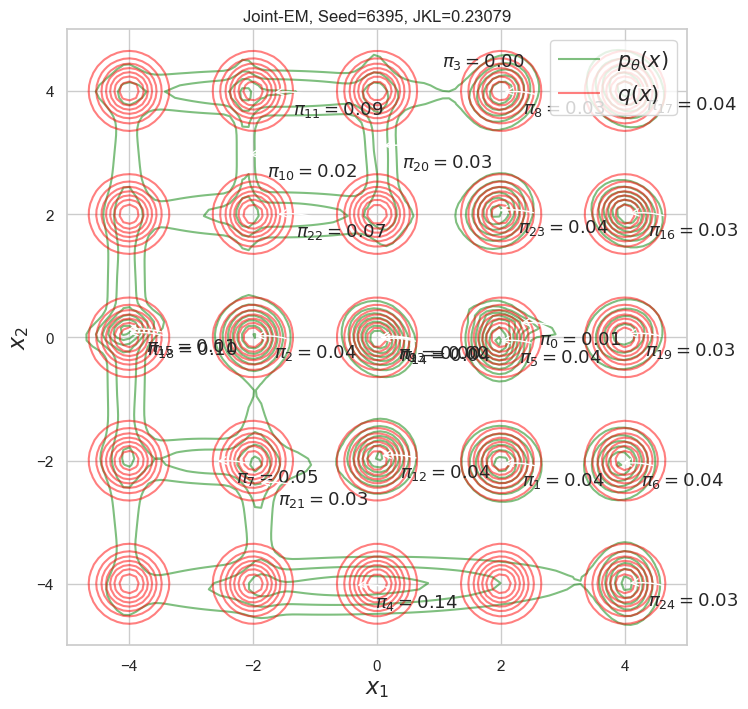

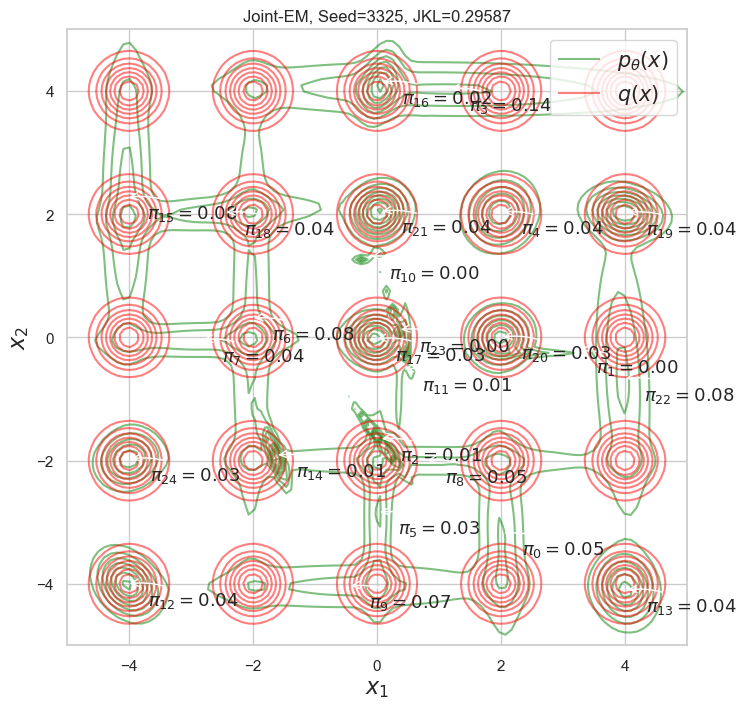

In [7]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

jointKLS = [torch.stack(jointKL_testS_ALL[ii]) for ii in range(len(random_seedS))]
data = pd.DataFrame(torch.stack(jointKLS, 1), columns=random_seedS.numpy())
# data = data.rolling(7, min_periods=1).mean()
sns.lineplot(data=data, palette="tab10", linewidth=2.5)
plt.ylim([0, 1])
plt.title('Joint-EM wrt random seeds')
plt.show() 

plt.plot(jointITS_ALL[0], jointKL_testS_ALL[0], 'r-', label='JointKL')
plt.plot(jointITS_ALL[0], Margin1KL_testS_ALL[0], 'g-', label='Margin1KL')
plt.plot(jointITS_ALL[0], Margin2KL_testS_ALL[0], 'b-', label='Margin2KL')
plt.plot(jointITS_ALL[0], Condition1KL_testS_ALL[0], 'm-', label='Condition1KL')
plt.plot(jointITS_ALL[0], Condition2KL_testS_ALL[0], 'k-', label='Condition2KL')
plt.legend()
plt.show()


for ii in range(3):
    
    pi_p, mu_p, Sigma_p = Theta_ALL[ii]
    
    contourplot_gmm_Full(pi_q, mu_q, Sigma_q, pi_p, mu_p, Sigma_p, fontsize=13)
    plt.xlabel('$x_1$', fontsize=16)
    plt.ylabel('$x_2$', fontsize=16)
    plt.title('Joint-EM, Seed=%d, JKL=%.5f' % (random_seedS[ii], jointKL_testS_ALL[ii][-1]))
    plt.show()


<2> BigLearn-EM

In [8]:
BigLearnKL_testS_ALL, BigLearnITS_ALL = [], []
Margin1KL_testS_ALL, Margin2KL_testS_ALL = [], []
Condition1KL_testS_ALL, Condition2KL_testS_ALL = [], []
AMargin1KL_testS_ALL, AMargin2KL_testS_ALL = [], []

BigLearnTheta_ALL = []

In [9]:
Amethod = 'orthogonal'  # 'orthogonal', 'rotation'
Amode = 'rand'  # rand  fix10
alpha_pi = 1. / (num_component ** 0.5)
NITnei = 5  # 5, 10

In [10]:
if False: 
    for irand, random_seed in enumerate(random_seedS):
        seed_torch(random_seed)
        x_all, y_all = GMM_sample_n(pi_q, mu_q, std_q, num_data)
        x_test, y_test = GMM_sample_n(pi_q, mu_q, std_q, num_data_test)
    
        # Aset = []
        # for _ in range(10):
        #     Aset.append(rand_mat(dim=x_dim, method=Amethod))
        
        JointKL_testS, ITS = [], []
        Margin1KL_testS, Margin2KL_testS = [], []
        Condition1KL_testS, Condition2KL_testS = [], []
    
        pi_p = 1. / num_component * torch.ones(num_component, 1, device=device)
        mu_p = torch.randn(num_component, x_dim, device=device)
        Sigma_p = torch.diag_embed(torch.ones(num_component, x_dim, device=device))
        
        for IT in range(Niter):
                
            if True:
                urand = torch.rand(1)
                if urand < 0.4:
                    case = 2
                elif urand < 0.5:
                    caseSet = torch.tensor([0, 1])
                    case = caseSet[torch.randint(len(caseSet), [1, ])]
                else:  # if urand < 1:
                    caseSet = torch.tensor([5, 6])
                    case = caseSet[torch.randint(len(caseSet), [1, ])]
            else:
                caseSet = torch.tensor([4])
                case = caseSet[torch.randint(len(caseSet), [1, ])]
    
            if case == 0:  # Marginal1
                mask_s, mask_t = torch.tensor([0, 0]), torch.tensor([1, 0])
            elif case == 1:  # Marginal2
                mask_s, mask_t = torch.tensor([0, 0]), torch.tensor([0, 1])
            elif case == 2:  # joint
                mask_s, mask_t = torch.tensor([0, 0]), torch.tensor([1, 1])
            elif case == 5:  # Marginal1 + Rotation
                if Amode == 'rand':
                    A = rand_mat(dim=x_dim, method=Amethod)  # rotation orthogonal
                else:
                    A = Aset[torch.randint(len(Aset), [1, ])]
                mask_s, mask_t = torch.tensor([0, 0]), torch.tensor([1, 0])
            elif case == 6:  # Marginal2 + Rotation
                if Amode == 'rand':
                    A = rand_mat(dim=x_dim, method=Amethod)  # rotation orthogonal
                else:
                    A = Aset[torch.randint(len(Aset), [1, ])]
                mask_s, mask_t = torch.tensor([0, 0]), torch.tensor([0, 1])           
                    
            if case in [0, 1, 2]:  # Joint, Marginal
                Tindx = mask_t > 0
                Tx = torch.where(Tindx)[0]  # K,D,D
                Tx1, Tx2, Tx3 = torch.meshgrid(torch.arange(mu_p.shape[0]), Tx, Tx)
    
                for iii in range(NITnei):
                    # E
                    log_gmm, log_piNormal, _ = GMM_logprobs_Full(x_all[:, Tindx], pi_p, mu_p[:, Tindx],
                                                                 Sigma_p[Tx1, Tx2, Tx3])  # N,1  N,K
                    qzgx = (log_piNormal - log_gmm).exp()  # N,K
    
                    # M
                    pi_p1 = qzgx.mean(0).unsqueeze(-1)  # K,1
                    mu_p[:, Tindx] = (qzgx.unsqueeze(2) * x_all[:, Tindx].unsqueeze(1)
                                      ).mean(0) / torch.maximum(epsilon, pi_p1)  # K,D
                    x_mu = x_all[:, Tindx].unsqueeze(1) - mu_p[:, Tindx].unsqueeze(0)  # N,K,D
                    Sigma_p[Tx1, Tx2, Tx3] = (qzgx.unsqueeze(2).unsqueeze(3) *
                                              torch.matmul(x_mu.unsqueeze(-1), x_mu.unsqueeze(-2))
                                              ).mean(0) / torch.maximum(epsilon, pi_p1).unsqueeze(-1)  # K,D,D
                    Sigma_p = correct_Sigma(Sigma_p)
                    
                    pi_p = (pi_p1 + alpha_pi)
                    pi_p = pi_p / pi_p.sum()
                    # pi_p = pi_p1
            
            elif case in [5, 6]:  # Marginal + Rotation/Orthogonal
                Tindx = mask_t > 0
                Tx = torch.where(Tindx)[0]  # K,D,D
                Tx1, Tx2, Tx3 = torch.meshgrid(torch.arange(mu_p.shape[0]), Tx, Tx)
    
                y_all = x_all.mm(A.t())
                bar_mu_p = mu_p.mm(A.t())
                bar_Sigma_p = torch.matmul(A.unsqueeze(0), torch.matmul(Sigma_p, A.t()))
    
                for iii in range(NITnei):
                    # E - A space
                    log_gmm, log_piNormal, _ = GMM_logprobs_Full(y_all[:, Tindx], pi_p, bar_mu_p[:, Tindx],
                                                                 bar_Sigma_p[Tx1, Tx2, Tx3])  # N,1  N,K
                    qzgy = (log_piNormal - log_gmm).exp()  # N,K
    
                    # M - A space
                    pi_p1 = qzgy.mean(0).unsqueeze(-1)  # K,1
                    bar_mu_p[:, Tindx] = (qzgy.unsqueeze(2) * y_all[:, Tindx].unsqueeze(1)
                                          ).mean(0) / torch.maximum(epsilon, pi_p1)  # K,D  Can assign values
                    y_mu = y_all[:, Tindx].unsqueeze(1) - bar_mu_p[:, Tindx].unsqueeze(0)  # N,K,D
                    bar_Sigma_p[Tx1, Tx2, Tx3] = (qzgy.unsqueeze(2).unsqueeze(3) *
                                                  torch.matmul(y_mu.unsqueeze(-1), y_mu.unsqueeze(-2))
                                                  ).mean(0) / torch.maximum(epsilon, pi_p1).unsqueeze(-1)  # K,D,D
                    bar_Sigma_p = correct_Sigma(bar_Sigma_p)
    
                    # to original space
                    mu_p = bar_mu_p.mm(A)
                    Sigma_p = torch.matmul(A.t().unsqueeze(0), torch.matmul(bar_Sigma_p, A))
                    Sigma_p = correct_Sigma(Sigma_p)
    
                    pi_p = (pi_p1 + alpha_pi)
                    pi_p = pi_p / pi_p.sum()
                    # pi_p = pi_p1

            jointKL_test = KL_gmm_Full(x_test, pi_q, mu_q, Sigma_q, pi_p, mu_p, Sigma_p)
            JointKL_testS.append(jointKL_test)
            ITS.append(IT)
        
            Tindx1 = torch.tensor([1, 0]) > 0
            Tx = torch.where(Tindx1)[0]  # K,D,D
            Tx1, Tx2, Tx3 = torch.meshgrid(torch.arange(mu_p.shape[0]), Tx, Tx)
            Margin1KL_testS.append(
                KL_gmm_Full(x_test[:, Tindx1], pi_q, mu_q[:, Tindx1], Sigma_q[Tx1, Tx2, Tx3], pi_p, mu_p[:, Tindx1],
                            Sigma_p[Tx1, Tx2, Tx3])
            )
        
            Tindx2 = torch.tensor([0, 1]) > 0
            Tx = torch.where(Tindx2)[0]  # K,D,D
            Tx1, Tx2, Tx3 = torch.meshgrid(torch.arange(mu_p.shape[0]), Tx, Tx)
            Margin2KL_testS.append(
                KL_gmm_Full(x_test[:, Tindx2], pi_q, mu_q[:, Tindx2], Sigma_q[Tx1, Tx2, Tx3], pi_p, mu_p[:, Tindx2],
                            Sigma_p[Tx1, Tx2, Tx3])
            )
        
            Sindx1 = torch.tensor([0, 1]) > 0
            Tindx1 = torch.tensor([1, 0]) > 0
            Condition1KL_testS.append(
                KL_gmm_condition_Full(x_test, pi_q, mu_q, Sigma_q, pi_p, mu_p, Sigma_p, Sindx1, Tindx1)
            )
        
            Sindx2 = torch.tensor([1, 0]) > 0
            Tindx2 = torch.tensor([0, 1]) > 0
            Condition2KL_testS.append(
                KL_gmm_condition_Full(x_test, pi_q, mu_q, Sigma_q, pi_p, mu_p, Sigma_p, Sindx2, Tindx2)
            )
    
            if IT % 100 ==0:
                print('irand=%d, random_seed=%d, IT=%d, JointKL=%.5f, Margin1KL=%.5f, Margin2KL=%.5f, Condition1KL=%.5f, Condition2KL=%.5f' % (
                    irand, random_seed, IT, JointKL_testS[-1], Margin1KL_testS[-1], Margin2KL_testS[-1], Condition1KL_testS[-1], Condition2KL_testS[-1]))
    
        # JEM_Pr2MARN5_KLtestS_ALL.append(JointKL_testS)
        # ITS_ALL.append(ITS)
        BigLearnKL_testS_ALL.append(JointKL_testS)
        BigLearnITS_ALL.append(ITS)
        Margin1KL_testS_ALL.append(Margin1KL_testS)
        Margin2KL_testS_ALL.append(Margin2KL_testS)
        Condition1KL_testS_ALL.append(Condition1KL_testS)
        Condition2KL_testS_ALL.append(Condition2KL_testS)

        # JEM_Pr2MARN5_Theta_ALL.append((pi_p, mu_p, Sigma_p))
        BigLearnTheta_ALL.append((pi_p, mu_p, Sigma_p))
    
    # torch.save((JEM_Pr2MARN5_KLtestS_ALL, ITS_ALL, Margin1KL_testS_ALL, Margin2KL_testS_ALL, Condition1KL_testS_ALL, Condition2KL_testS_ALL, JEM_Pr2MARN5_Theta_ALL, random_seedS),
    #            out_dir + 'JEM_Pr2MARN5_States_AllSeeds_Full.pt')
    torch.save((BigLearnKL_testS_ALL, BigLearnITS_ALL, Margin1KL_testS_ALL, Margin2KL_testS_ALL, Condition1KL_testS_ALL, Condition2KL_testS_ALL, BigLearnTheta_ALL, random_seedS),
               out_dir + 'BiglearnEM_States_AllSeeds_Full.pt')

else:
    # JEM_Pr2MARN5_KLtestS_ALL, ITS_ALL, Margin1KL_testS_ALL, Margin2KL_testS_ALL, Condition1KL_testS_ALL, Condition2KL_testS_ALL, JEM_Pr2MARN5_Theta_ALL, random_seedS = torch.load(out_dir + 'JEM_Pr2MARN5_States_AllSeeds_Full.pt')
    BigLearnKL_testS_ALL, BigLearnITS_ALL, Margin1KL_testS_ALL, Margin2KL_testS_ALL, Condition1KL_testS_ALL, Condition2KL_testS_ALL, BigLearnTheta_ALL, random_seedS = torch.load(out_dir + 'BiglearnEM_States_AllSeeds_Full.pt')


C:\Users\Air540\AppData\Local\Temp\ipykernel_21428\580480763.py:21: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


irand=0, random_seed=5079, IT=0, JointKL=2.41359, Margin1KL=1.01877, Margin2KL=0.50388, Condition1KL=1.90971, Condition2KL=1.39482
irand=0, random_seed=5079, IT=100, JointKL=0.43549, Margin1KL=0.09022, Margin2KL=0.10325, Condition1KL=0.33224, Condition2KL=0.34527
irand=0, random_seed=5079, IT=200, JointKL=0.28770, Margin1KL=0.04436, Margin2KL=0.06438, Condition1KL=0.22332, Condition2KL=0.24334
irand=0, random_seed=5079, IT=300, JointKL=0.08679, Margin1KL=0.00848, Margin2KL=0.01361, Condition1KL=0.07318, Condition2KL=0.07831
irand=0, random_seed=5079, IT=400, JointKL=0.04854, Margin1KL=0.00394, Margin2KL=0.00634, Condition1KL=0.04221, Condition2KL=0.04461
irand=0, random_seed=5079, IT=500, JointKL=0.06402, Margin1KL=0.00513, Margin2KL=0.00669, Condition1KL=0.05734, Condition2KL=0.05890
irand=0, random_seed=5079, IT=600, JointKL=0.04855, Margin1KL=0.00394, Margin2KL=0.00634, Condition1KL=0.04221, Condition2KL=0.04461
irand=0, random_seed=5079, IT=700, JointKL=0.07610, Margin1KL=0.00444, 

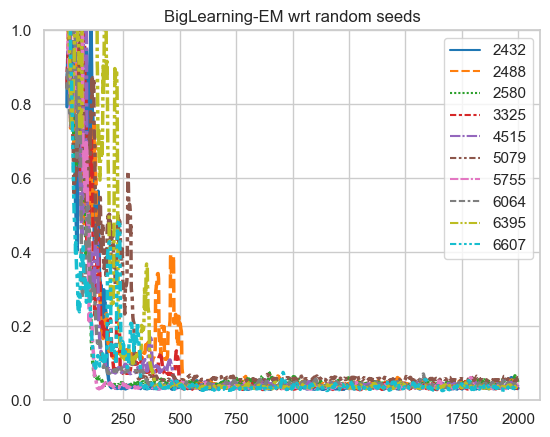

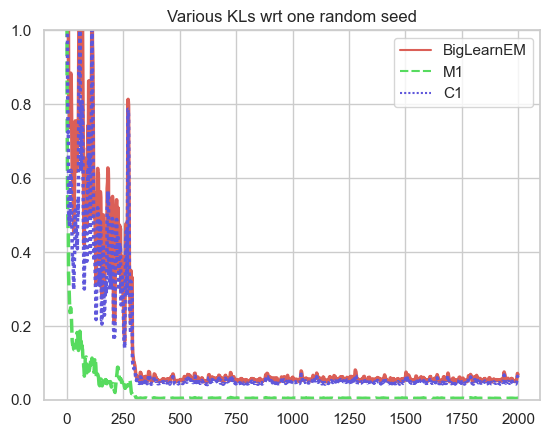

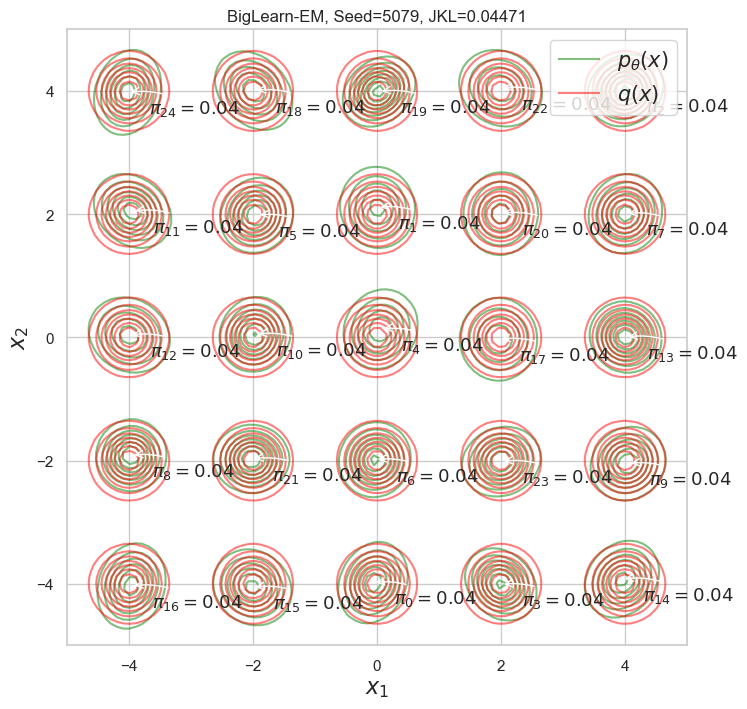

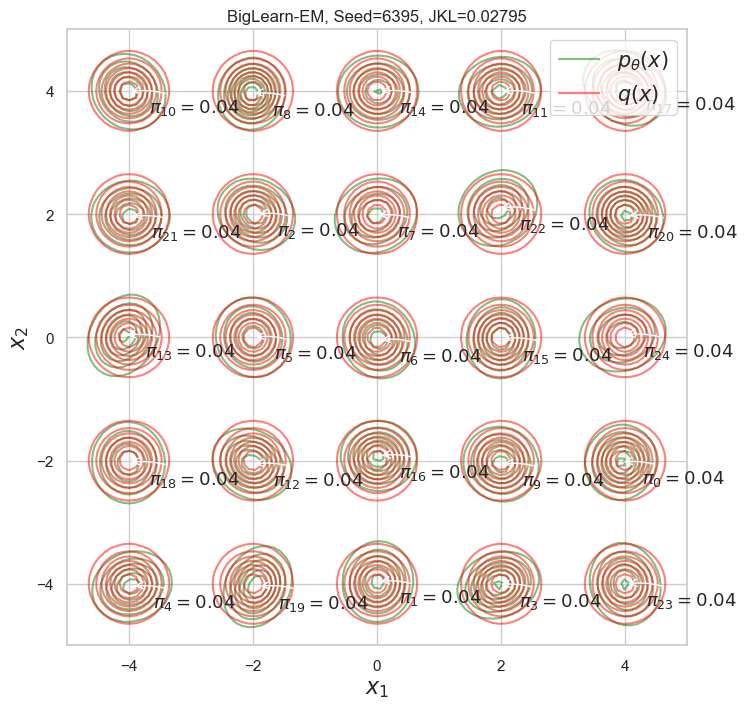

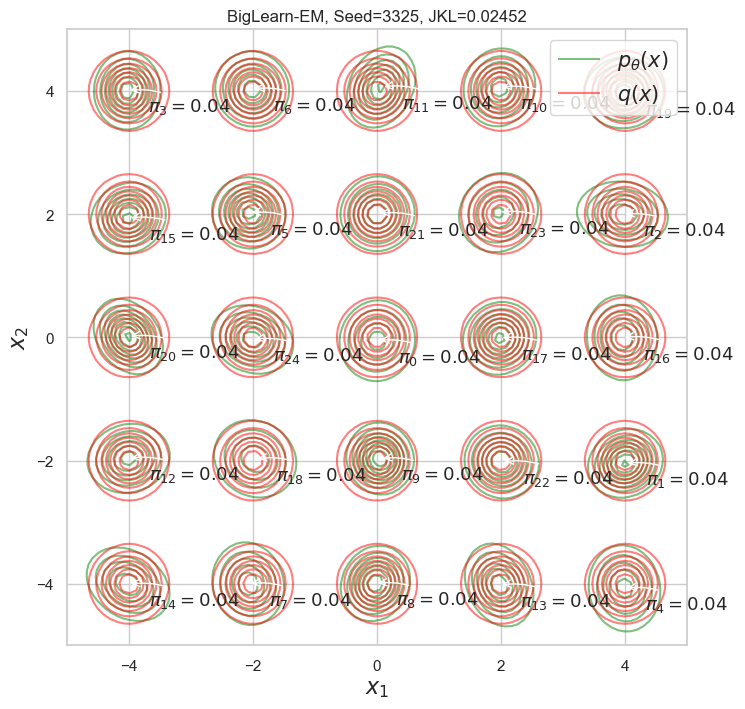

In [12]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

jointKLS = [torch.stack(BigLearnKL_testS_ALL[ii]) for ii in range(len(random_seedS))]
data = pd.DataFrame(torch.stack(jointKLS, 1), columns=random_seedS.numpy())
data = data.rolling(15, min_periods=1).mean()
sns.lineplot(data=data, palette="tab10", linewidth=2.5)
plt.ylim([0, 1])
plt.title('BigLearning-EM wrt random seeds')
plt.show() 

OneSeed = []
OneSeed.append(torch.stack(BigLearnKL_testS_ALL[0]))
OneSeed.append(torch.stack(Margin1KL_testS_ALL[0]))
OneSeed.append(torch.stack(Condition1KL_testS_ALL[0]))
# for ii in range(len(random_seedS)):
#     OneSeed.append(torch.stack(AMargin1KL_testS_ALL[0][ii]))
KLsOneSeed = torch.stack(OneSeed, 1)
# columns = ['BigLearnEM', 'M1', 'C1', 'A01', 'A11', 'A21', 'A31', 'A41', 'A51', 'A61', 'A71', 'A81', 'A91']
columns = ['BigLearnEM', 'M1', 'C1']
data = pd.DataFrame(KLsOneSeed, columns=columns)
data = data.rolling(7, min_periods=1).mean()
sns.lineplot(data=data, palette=sns.color_palette("hls", len(columns)), linewidth=2.5)
plt.ylim([0, 1])
plt.title('Various KLs wrt one random seed')
plt.show() 

for ii in range(3):
    pi_p, mu_p, Sigma_p = BigLearnTheta_ALL[ii]
    
    contourplot_gmm_Full(pi_q, mu_q, Sigma_q, pi_p, mu_p, Sigma_p, fontsize=13)
    plt.xlabel('$x_1$', fontsize=16)
    plt.ylabel('$x_2$', fontsize=16)
    plt.title('BigLearn-EM, Seed=%d, JKL=%.5f' % (random_seedS[ii], min(BigLearnKL_testS_ALL[ii])))
    plt.show()


In [13]:
jointKL_testS_ALL, jointITS_ALL, Margin1KL_testS_ALL, Margin2KL_testS_ALL, Condition1KL_testS_ALL, Condition2KL_testS_ALL, Theta_ALL, random_seedS = torch.load(out_dir + 'JointEM_States_AllSeeds_Full.pt')

JointEM_TestKL = [min(jointKL_testS_ALL[ii]) for ii in range(len(random_seedS))]


In [14]:
BigLearnKL_testS_ALL, BigLearnITS_ALL, Margin1KL_testS_ALL, Margin2KL_testS_ALL, Condition1KL_testS_ALL, Condition2KL_testS_ALL, BigLearnTheta_ALL, random_seedS = torch.load(out_dir + 'BiglearnEM_States_AllSeeds_Full.pt')

BigLearnEM_TestKL = [min(BigLearnKL_testS_ALL[ii]) for ii in range(len(random_seedS))]


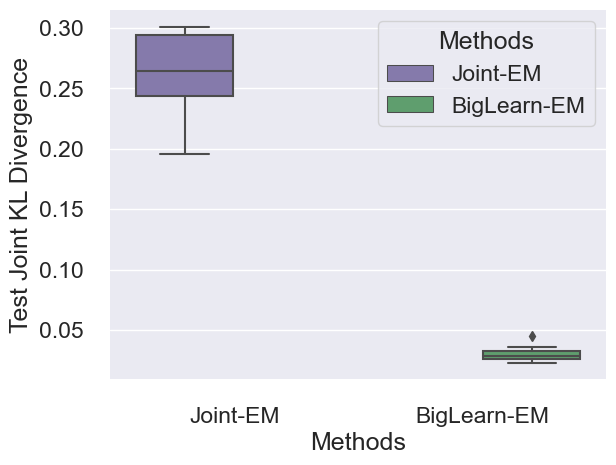

In [15]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

data = pd.DataFrame()
data['Methods'] = ('Joint-EM',) * 10 + ('BigLearn-EM',) * 10
data['Test Joint KL Divergence'] = torch.stack(JointEM_TestKL + BigLearnEM_TestKL).numpy()
data['Seed'] = torch.cat((random_seedS, random_seedS))
# sns.set_theme(style="ticks", palette="pastel")

sns.set(font_scale = 1.5)
sns.boxplot(x="Methods", y="Test Joint KL Divergence",
            hue="Methods", palette=["m", "g"],
            data=data)
sns.despine(offset=10, trim=True)


In [16]:
data.groupby('Methods').describe()

Test Joint KL Divergence                                         \
                               count      mean       std      min       25%   
Methods                                                                       
BigLearn-EM                     10.0  0.030138  0.006392  0.02295  0.025895   
Joint-EM                        10.0  0.263266  0.034652  0.19538  0.243661   

                                           Seed                               \
                  50%       75%       max count    mean          std     min   
Methods                                                                        
BigLearn-EM  0.028555  0.032424  0.044714  10.0  4524.0  1692.240264  2432.0   
Joint-EM     0.264564  0.293947  0.301195  10.0  4524.0  1692.240264  2432.0   

                                               
                 25%     50%      75%     max  
Methods                                        
BigLearn-EM  2766.25  4797.0  5986.75  6607.0  
Joint-EM     2766.25  4797.0  5986.75  6607.0

In [17]:
curr_time = time.strftime("%H:%M:%S", time.localtime())
print("Current Time is :", curr_time)

Current Time is : 14:16:25
